In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report


In [2]:
df = pd.read_csv('df_positif_top_14.csv', low_memory=False)
df

,cas_id,unit,substance,value,isomer,index_original
0,335-67-1,ng/l,PFOA,90.0,NaN,12991
1,1763-23-1,ng/l,PFOS,40.0,NaN,12991
2,335-67-1,ng/l,PFOA,200.0,NaN,12992
3,335-67-1,ng/l,PFOA,41400.0,NaN,12993
4,1763-23-1,ng/l,PFOS,500.0,NaN,12993
...,...,...,...,...,...,...
567254,375-73-5,ng/l,PFBS,2.7,NaN,466666
567255,375-22-4,ng/l,PFBA,2.5,NaN,466666
567256,2706-90-3,ng/l,PFPeA,1.7,NaN,466666
567257,307-24-4,ng/l,PFHxA,1.5,NaN,466666


In [3]:
df_preproc = df[['cas_id', 'value']]
df_preproc

,cas_id,value
0,335-67-1,90.0
1,1763-23-1,40.0
2,335-67-1,200.0
3,335-67-1,41400.0
4,1763-23-1,500.0
...,...,...
567254,375-73-5,2.7
567255,375-22-4,2.5
567256,2706-90-3,1.7
567257,307-24-4,1.5


In [4]:
cas_id_filter = '1763-23-1'
PFOS = df_preproc[df_preproc['cas_id'] == cas_id_filter]
PFOS

,cas_id,value
1,1763-23-1,40.0
4,1763-23-1,500.0
7,1763-23-1,20.0
11,1763-23-1,10.0
15,1763-23-1,30.2
...,...,...
567226,1763-23-1,1.8
567229,1763-23-1,17.0
567235,1763-23-1,7.5
567245,1763-23-1,3.0


In [36]:
from sklearn.cluster import KMeans
# Appliquer K-Means avec 1 cluster (car nous voulons trouver une anomalie par rapport à un centre)
kmeans = KMeans(n_clusters=1, random_state=0)
kmeans.fit(PFOS[['value']])

# Calculer la distance de chaque point au centre du cluster
PFOS['distance_to_center'] = np.linalg.norm(PFOS[['value']] - kmeans.cluster_centers_, axis=1)

# Définir une anomalie comme un point situé à une grande distance du centre
threshold = np.percentile(PFOS['distance_to_center'], 95)  # Par exemple, les 5% les plus éloignés
PFOS['anomaly'] = (PFOS['distance_to_center'] > threshold).astype(int)
decision_boundary = np.percentile(PFOS['distance_to_center'], 95)
print(f"Valeur de la frontière de décision (95e percentile) : {decision_boundary}")

Valeur de la frontière de décision (95e percentile) : 8828.891240986954


C:\Users\User\AppData\Local\Temp\ipykernel_1852\258479250.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PFOS['distance_to_center'] = np.linalg.norm(PFOS[['value']] - kmeans.cluster_centers_, axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_1852\258479250.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PFOS['anomaly'] = (PFOS['distance_to_center'] > threshold).astype(int)


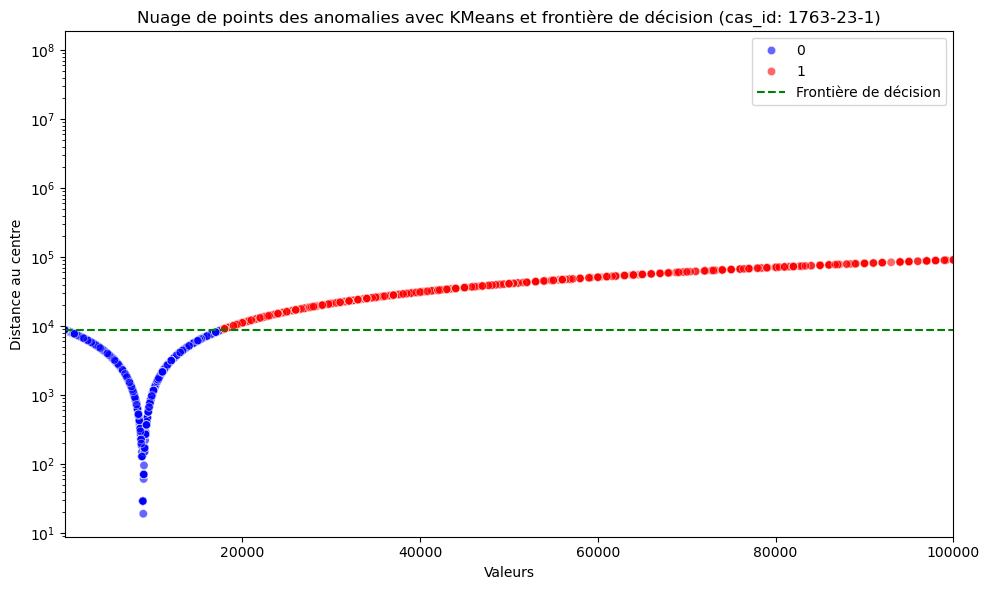

In [64]:
# Visualisation sous forme de nuage de points avec la frontière de décision
plt.figure(figsize=(10, 6))

# Tracer les points normaux et les anomalies
sns.scatterplot(x=PFOS['value'], y=PFOS['distance_to_center'], hue='anomaly', data=PFOS, palette={0: 'blue', 1: 'red'}, alpha=0.6)

# Tracer la frontière de décision (seuil)
plt.axhline(y=threshold, color='green', linestyle='--', label='Frontière de décision')
plt.yscale('log')
plt.xlim(1e-2, 1e5)
# Ajouter des titres et des labels
plt.title('Nuage de points des anomalies avec KMeans et frontière de décision (cas_id: 1763-23-1)')
plt.xlabel('Valeurs')
plt.ylabel('Distance au centre')
plt.legend()

# Afficher le graphique
plt.tight_layout()
plt.show()

In [66]:
# 4ng/l étant le seuil à ne pas dépacer
masque_pfOS = PFOS['value'] > 4

df_pfOS_filtre = PFOS[masque_pfOS]

df_pfOS_filtre.shape

(75448, 4)

In [52]:
df_pfOS_filtre

,cas_id,value,distance_to_center,anomaly
1,1763-23-1,40.0,8789.141241,0
4,1763-23-1,500.0,8329.141241,0
7,1763-23-1,20.0,8809.141241,0
11,1763-23-1,10.0,8819.141241,0
15,1763-23-1,30.2,8798.941241,0
...,...,...,...,...
567085,1763-23-1,5.0,8824.141241,0
567088,1763-23-1,6.3,8822.841241,0
567114,1763-23-1,4.3,8824.841241,0
567229,1763-23-1,17.0,8812.141241,0
